In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler

import optuna
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import json

plt.rc('font', family='NanumBarunGothic')

In [2]:
train_df = pd.read_csv(r"C:\Users\User\LG_Aimers\MainTask\train.csv")
train_id = train_df.pop('ID')
test_df = pd.read_csv(r"C:\Users\User\LG_Aimers\MainTask\test.csv")
test_id = test_df.pop('ID')

In [3]:
categorical_columns = [
    "시술 시기 코드",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "난자 출처",
    "정자 출처",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

In [4]:
numeric_columns = [
    "시술 당시 나이",
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 기증자 나이",
    "정자 기증자 나이"
]

In [5]:
times_values = ["총 시술 횟수",
                "클리닉 내 총 시술 횟수",
                "IVF 시술 횟수",
                "DI 시술 횟수",
                "총 임신 횟수",
                "IVF 임신 횟수",
                "DI 임신 횟수",
                "총 출산 횟수",
                "IVF 출산 횟수",
                "DI 출산 횟수"]

donar_age_values = ["난자 기증자 나이", "정자 기증자 나이"]

train_df["시술 당시 나이"] = train_df["시술 당시 나이"].map({
    "만18-34세" : 1,
    "만35-37세" : 2,
    "만38-39세" : 3,
    "만40-42세" : 4,
    "만43-44세" : 5,
    "만45-50세" : 6,
    "알 수 없음" : 0
})

train_df[times_values] = train_df[times_values].map(lambda x : int(x[0]))

for donar_age_value in donar_age_values:
    train_df[donar_age_value] = train_df[donar_age_value].map({
        '만20세 이하' : 1,
        '만21-25세' : 2,
        '만26-30세' : 3,
        '만31-35세' : 4,
        '만36-40세' : 5,
        '만41-45세' : 6,
        "알 수 없음" : 0
    })

test_df["시술 당시 나이"] = test_df["시술 당시 나이"].map({
    "만18-34세" : 1,
    "만35-37세" : 2,
    "만38-39세" : 3,
    "만40-42세" : 4,
    "만43-44세" : 5,
    "만45-50세" : 6,
    "알 수 없음" : 0
})

test_df[times_values] = test_df[times_values].map(lambda x : int(x[0]))

for donar_age_value in donar_age_values:
    test_df[donar_age_value] = test_df[donar_age_value].map({
        '만20세 이하' : 1,
        '만21-25세' : 2,
        '만26-30세' : 3,
        '만31-35세' : 4,
        '만36-40세' : 5,
        '만41-45세' : 6,
        "알 수 없음" : 0
    })

In [6]:
# Fill missing values in numeric columns using the mean
train_df[numeric_columns] = train_df[numeric_columns].fillna(train_df[numeric_columns].median())
test_df[numeric_columns] = test_df[numeric_columns].fillna(train_df[numeric_columns].median())

train_df = train_df.fillna("NA")
test_df = test_df.fillna("NA")

In [7]:
if train_df.isnull().any().any():
    print(train_df.isnull().sum())
if test_df.isnull().any().any():
    print(test_df.isnull().sum())

In [9]:
# Convert categorical columns to category dtype
for col in categorical_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype("category")
        test_df[col] = test_df[col].astype("category")
    else:
        categorical_columns.remove(col)

In [10]:
# Function to safely divide and replace division by zero with 99
def safe_divide(numerator, denominator):
    return numerator / (denominator + 1e-6)

# Apply the safe division function to each calculation
train_df["미세주입에서 생성된 배아 비율1"] = safe_divide(train_df["미세주입에서 생성된 배아 수"], train_df["총 생성 배아 수"])
test_df["미세주입에서 생성된 배아 비율1"] = safe_divide(test_df["미세주입에서 생성된 배아 수"], test_df["총 생성 배아 수"])

train_df["저장된 배아 비율"] = safe_divide(train_df["저장된 배아 수"], train_df["총 생성 배아 수"])
test_df["저장된 배아 비율"] = safe_divide(test_df["저장된 배아 수"], test_df["총 생성 배아 수"])

train_df["미세주입 후 저장된 배아 비율"] = safe_divide(train_df["미세주입 후 저장된 배아 수"], train_df["저장된 배아 수"])
test_df["미세주입 후 저장된 배아 비율"] = safe_divide(test_df["미세주입 후 저장된 배아 수"], test_df["저장된 배아 수"])

train_df["혼합된 난자 비율"] = safe_divide(train_df["혼합된 난자 수"], train_df["수집된 신선 난자 수"] + train_df["해동 난자 수"])
test_df["혼합된 난자 비율"] = safe_divide(test_df["혼합된 난자 수"], test_df["수집된 신선 난자 수"] + test_df["해동 난자 수"])

train_df["저장된 신선 난자 비율"] = safe_divide(train_df["저장된 신선 난자 수"], train_df["수집된 신선 난자 수"])
test_df["저장된 신선 난자 비율"] = safe_divide(test_df["저장된 신선 난자 수"], test_df["수집된 신선 난자 수"])

train_df["미세주입된 난자 비율"] = safe_divide(train_df["미세주입된 난자 수"], train_df["혼합된 난자 수"])
test_df["미세주입된 난자 비율"] = safe_divide(test_df["미세주입된 난자 수"], test_df["혼합된 난자 수"])


In [14]:
# Apply to multiple numerical columns
scaler = RobustScaler()
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])
test_df[numeric_columns] = scaler.transform(test_df[numeric_columns])

# 학습

# H2O ai


In [34]:
import h2o
h2o.init()
h2o.cluster_info()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.431-b10, mixed mode)
  Starting server from C:\Users\User\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmpd_8is87u
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmpd_8is87u\h2o_User_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmpd_8is87u\h2o_User_started_from_python.err
  Server is running at http://127.0.0.1:54321
 successful.o H2O server at http://127.0.0.1:54321 ...
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 16 days
H2O_cluster_name:,H2O_from_python_User_3vc8ky
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.390 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


C:\Users\User\AppData\Local\Temp\ipykernel_11868\951545792.py:7: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().show_status()``.
  h2o.cluster_info()


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 16 days
H2O_cluster_name:,H2O_from_python_User_3vc8ky
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.390 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [44]:
import pandas as pd

df = train_df.drop(['임신 성공 여부'],axis=1)
df['target'] = train_df['임신 성공 여부']
h2o_df = h2o.H2OFrame(df)
h2o_df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,남성 부 불임 원인,여성 주 불임 원인,여성 부 불임 원인,부부 주 불임 원인,부부 부 불임 원인,불명확 불임 원인,불임 원인 - 난관 질환,불임 원인 - 남성 요인,불임 원인 - 배란 장애,불임 원인 - 여성 요인,불임 원인 - 자궁경부 문제,불임 원인 - 자궁내막증,불임 원인 - 정자 농도,불임 원인 - 정자 면역학적 요인,불임 원인 - 정자 운동성,불임 원인 - 정자 형태,배아 생성 주요 이유,총 시술 횟수,클리닉 내 총 시술 횟수,IVF 시술 횟수,DI 시술 횟수,총 임신 횟수,IVF 임신 횟수,DI 임신 횟수,총 출산 횟수,IVF 출산 횟수,DI 출산 횟수,총 생성 배아 수,미세주입된 난자 수,미세주입에서 생성된 배아 수,이식된 배아 수,미세주입 배아 이식 수,저장된 배아 수,미세주입 후 저장된 배아 수,해동된 배아 수,해동 난자 수,수집된 신선 난자 수,저장된 신선 난자 수,혼합된 난자 수,파트너 정자와 혼합된 난자 수,기증자 정자와 혼합된 난자 수,난자 출처,정자 출처,난자 기증자 나이,정자 기증자 나이,동결 배아 사용 여부,신선 배아 사용 여부,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,미세주입에서 생성된 배아 비율1,저장된 배아 비율,미세주입 후 저장된 배아 비율,혼합된 난자 비율,저장된 신선 난자 비율,미세주입된 난자 비율,target
시술 시기 코드,nan,nan,시술 유형,특정 시술 유형,nan,배란 유도 유형,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,배아 생성 주요 이유,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,난자 출처,정자 출처,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TRZKPL,-0.5,0,IVF,ICSI,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,현재 시술용,-0.5,-0.5,-0.5,0,0,0,0,0,0,0,0,0.714286,0.8,1,1,2,2,0,0,-0.0909091,0,-0.25,-0.1,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,1,0.5,1,0.714286,0,1,0
TRYBLT,2,0,IVF,ICSI,0,알 수 없음,0,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,현재 시술용,-0.5,-0.5,-0.5,0,0,0,0,0,0,0,-0.571429,0.142857,0,-1,0,0,0,0,0,-0.636364,0,-0.75,-0.5,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,0,0,0,0.999999,0,0.999999,0
TRVNRY,-0.5,0,IVF,IVF,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,현재 시술용,0,-0.5,0,0,0,0,0,0,0,0,0.142857,0,0,1,0,0,0,0,0,0,0,0,0.1,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,-0.333333,0,0,0,0,0.875,0,0,0
TRJXFG,0,0,IVF,ICSI,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,현재 시술용,0,0,0,0,0,0,0,0,0,0,-0.571429,0.571429,0,-1,0,0,0,0,0,-0.272727,0,-0.375,-0.2,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,0,0,0,0.8,0,1,0
TRVNRY,-0.5,0,IVF,ICSI,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,현재 시술용,-0.5,-0.5,-0.5,0,0,0,0,0,0,0,0.285714,0.857143,1.2,1,1,0,0,0,0,-0.0909091,0,-0.125,0,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,1,0,0,0.857143,0,1,0
TRVNRY,0.5,0,IVF,ICSI,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,현재 시술용,-0.5,-0.5,-0.5,0,0,0,0,0,0,0,-0.142857,0.714286,0.6,1,1,0,0,0,0,-0.272727,0,-0.25,-0.1,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,1,0,0,1,0,1,0
TRJXFG,-0.5,0,IVF,ICSI,0,알 수 없음,1,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,현재 시술용,-0.5,-0.5,-0.5,0,0,0,0,0,0,0,0,0.571429,0.8,0,0.5,3,3,0,0,-0.727273,0,-0.375,-0.2,0,기증 제공,배우자 제공,2,0,0,1,0,0,nan,nan,0,0,0,-0.333333,0,1,0.75,1,4e+06,0,1,0
TRXQMD,1,0,IVF,IVF,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,현재 시술용,0,0,0,0,0,0,0,0,0,0,1.14286,0,0,1,0,0,0,0,0,0.636364,0,1,0.9,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0.666667,0,0,0,0,1,0,0,0
TRYBLT,0.5,0,IVF,IVF,1,기록되지 않은 시행,0,nan,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,현재 시술용,0,0,0,0,0,0,0,0,0,0,-0.571429,0,0,-1,0,0,0,0,0,-0.727273,0,-0.875,-0.6,0,본인 제공,배우자 제공,0,0,0,1,0,0,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=20, seed=1)

X = h2o_df.columns[:-1]  
y = 'target'  
aml.train(x=X, y=y, training_frame=h2o_df)
aml.leaderboard

AutoML progress: |
15:24:38.590: AutoML: XGBoost is not available; skipping it.
15:24:38.593: _train param, Dropping bad and constant columns: [착상 전 유전 검사 사용 여부, PGD 시술 여부, 불임 원인 - 여성 요인, PGS 시술 여부, 난자 채취 경과일]
15:24:38.593: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████████
15:25:32.321: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
15:26:02.139: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
15:28:11.248: _response param, We have detected that your response column h

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_5_AutoML_2_20250218_152438,0.407578,0.16612,0.334332,0.286318,0.16612
StackedEnsemble_BestOfFamily_1_AutoML_2_20250218_152438,0.407614,0.166149,0.334312,0.286265,0.166149
GBM_2_AutoML_2_20250218_152438,0.407653,0.166181,0.333746,0.286359,0.166181
GBM_3_AutoML_2_20250218_152438,0.40771,0.166228,0.333432,0.286382,0.166228
GBM_grid_1_AutoML_2_20250218_152438_model_3,0.407785,0.166289,0.335263,0.28646,0.166289
GBM_grid_1_AutoML_2_20250218_152438_model_2,0.407859,0.166349,0.335669,0.286471,0.166349
GBM_4_AutoML_2_20250218_152438,0.408353,0.166752,0.334012,0.286768,0.166752
GBM_1_AutoML_2_20250218_152438,0.408691,0.167029,0.333363,0.287084,0.167029
StackedEnsemble_AllModels_1_AutoML_2_20250218_152438,0.408773,0.167095,0.342486,0.286263,0.167095
GBM_grid_1_AutoML_2_20250218_152438_model_4,0.410247,0.168302,0.33644,0.288149,0.168302


C:\Users\User\AppData\Local\Temp\ipykernel_11868\3629116213.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=top_20_varimp_df, palette='viridis')


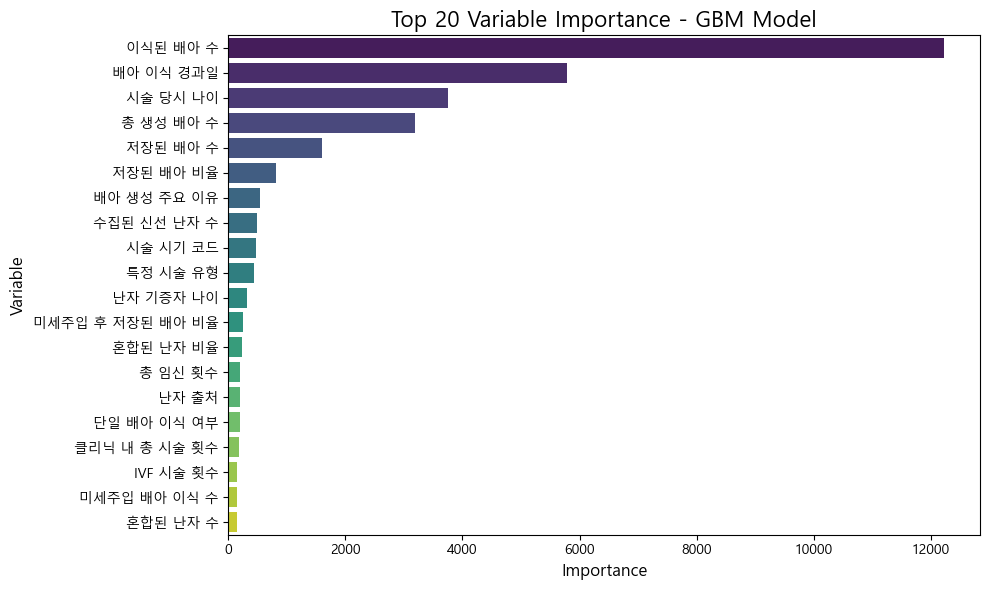

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

varimp = leader_model.varimp()
varimp_df = pd.DataFrame(varimp)
varimp_df.columns = ['Variable', 'Importance', 'Scaled Importance', 'Relative Importance']
varimp_df = varimp_df[['Variable', 'Importance']]
varimp_df = varimp_df.sort_values(by='Importance', ascending=False)

top_20_varimp_df = varimp_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=top_20_varimp_df, palette='viridis')
plt.title('Top 20 Variable Importance - GBM Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()


In [134]:
model_path = h2o.save_model(model=aml.leader, path=r"C:\Users\User\LG_Aimers\MainTask", force=True)

In [86]:
test_h2o = h2o.H2OFrame(test_df)
predictions = leader_model.predict(test_h2o)
predictions_df = predictions.as_data_frame()
print(predictions_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
        predict
0      0.217243
1      0.029684
2      0.010583
3      0.163781
4      0.117864
...         ...
90063  0.002864
90064  0.281906
90065  0.401268
90066  0.254308
90067  0.021514

[90068 rows x 1 columns]


C:\Users\User\anaconda3\Lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column '특정 시술 유형' has levels not trained on: ["IUI:ICI", "IVF:Unknown:Unknown:Unknown"]
  warnings.warn(w)
C:\Users\User\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# LIGHTGBM

In [414]:
#X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=['임신 성공 여부']), train_df['임신 성공 여부'], test_size=0.2, random_state=42, stratify=train_df['임신 성공 여부'])

def objective(trial):
    # Convert float categorical columns to int (if necessary)
    for col in categorical_columns:
        if train_df[col].dtype == 'float64':
            train_df[col] = train_df[col].astype(int)

    # Prepare dataset
    X = train_df.drop(columns=['임신 성공 여부'])
    y = train_df['임신 성공 여부']
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define hyperparameter search space
    params = {
        "objective": "binary",  # Binary classification
        "metric": "auc",  # Optimize AUC
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 20),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 3.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "random_state": 42,
        "verbose": -1,
    }

    # Create LightGBM datasets
    dtrain = lightgbm.Dataset(train_x, label=train_y, categorical_feature=categorical_columns, free_raw_data=False)
    dvalid = lightgbm.Dataset(valid_x, label=valid_y, reference=dtrain, categorical_feature=categorical_columns, free_raw_data=False)

    # Train the model
    model = lightgbm.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        valid_names=["valid"],
        num_boost_round=2000
    )

    # Predict probabilities for the positive class (1)
    y_pred_proba = model.predict(valid_x, num_iteration=model.best_iteration)

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(valid_y, y_pred_proba)

    return roc_auc

# Create a study and optimize
study = optuna.create_study(direction="maximize")  # Maximize ROC-AUC
study.optimize(objective, n_trials=50)

# Display the best hyperparameters
print("Best Hyperparameters:")
print(study.best_params)



[I 2025-02-17 18:10:06,068] A new study created in memory with name: no-name-cc14088a-d923-46d1-a5f5-32eaa9c8ab64
C:\Users\User\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-02-17 18:10:11,693] Trial 0 finished with value: 0.7265099121136938 and parameters: {'n_estimators': 795, 'learning_rate': 0.2176214543286663, 'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 19, 'min_child_weight': 0.6317154961557528, 'feature_fraction': 0.8620486305799798, 'bagging_fraction': 0.430496290065171, 'bagging_freq': 6, 'lambda_l1': 7.890467743749, 'lambda_l2': 7.329410947946081}. Best is trial 0 with value: 0.7265099121136938.
C:\Users\User\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead 

Best Hyperparameters:
{'n_estimators': 561, 'learning_rate': 0.016802759586309095, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 6, 'min_child_weight': 0.7613656039455767, 'feature_fraction': 0.8637301655049069, 'bagging_fraction': 0.8873166074937269, 'bagging_freq': 1, 'lambda_l1': 4.485288444658212, 'lambda_l2': 4.830235288443518}


In [468]:
# Prepare full dataset for training
X = train_df.drop(columns=['임신 성공 여부'])
y = train_df['임신 성공 여부']

# Define dataset for training without validation
dtrain = lightgbm.Dataset(X, label=y, categorical_feature=categorical_columns, free_raw_data=False)

In [470]:
# Train without validation
params = {'n_estimators': 561, 'learning_rate': 0.016802759586309095, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 6, 'min_child_weight': 0.7613656039455767, 'feature_fraction': 0.8637301655049069, 'bagging_fraction': 0.8873166074937269, 'bagging_freq': 1, 'lambda_l1': 4.485288444658212, 'lambda_l2': 4.830235288443518}
final_model = lightgbm.train(
    params,
    dtrain,
    num_boost_round=2000
)

C:\Users\User\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [472]:
pred = final_model.predict(test_df)

sample_df = pd.read_csv(r"C:\Users\User\LG_Aimers\MainTask/sample_submission.csv")
sample_df['probability'] = pred

In [474]:
sample_df.to_csv('submission.csv',encoding='utf-8-sig')